In [1]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab
import scipy #to save mat files
import time  #to time code

In [2]:
#balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsDw','StairsUp','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsDw','StairsUp','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def prec_rec(cmat):
    tpfp = cmat.sum(axis=1)
    tpfn = cmat.sum(axis=0)
    prec = cmat.diagonal()/tpfp
    recall = cmat.diagonal()/tpfn
    return prec,recall

### Load Data

In [89]:
HealthyData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/HealthyData.csv',verbose=False)
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientCBRData.csv',verbose=False)
SCOData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientSCOData.csv',verbose=False)

In [4]:
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
HealthyCodes = HealthyCodes.to_numpy()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
print PatientCodes

[51 52 53 54 55 56 57 58 59 60 61]
[1L, 2L, 5L, 6L, 8L, 11L, 12L, 13L, 14L, 15L, 16L, 19L, 21L, 24L]


In [5]:
PatientCodes = np.array([1, 2, 5, 6, 8, 11, 14, 15, 16, 19, 24]) #patients with enough sessions

### Use 3 sessions for CBR and SCO data. Remove stairs in CBR data for patients who don't have at least 2 sessions with stairs data

Inspect SCO Data

In [6]:
for s in PatientCodes:
    data = SCOData[SCOData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())

1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
1 5 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 3 4]
2 4 [0 1 2 3 4]
2 5 [0 3 4]
2 6 [3 4]
2 7 [0 2 3 4]
2 8 [0 1 3 4]
2 9 [0 3 4]
5 1 [0 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
6 1 [0 1 2 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
6 5 [0 1 2 3 4]
6 6 [1 2 3 4]
8 1 [0 1 2 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 3 4]
8 5 [0 3 4]
11 1 [0 3 4]
11 2 [0 3 4]
11 3 [0 3 4]
11 4 [0 1 2 3 4]
11 5 [0 1 2 3 4]
11 6 [0 1 2 3 4]
14 1 [0 1 2 3 4]
14 2 [0 1 2 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 3 4]
15 3 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
16 5 [0 1 2 3 4]
16 6 [0 3 4]
19 1 [0 3 4]
19 2 [0 1 2 3 4]
19 3 [0 3 4]
24 1 [0 1 2 3 4]
24 2 [0 1 2 3 4]
24 3 [0 1 2 3 4]


In [7]:
print SCOData.num_rows()

28276


Select the 3 sessions to keep for patients who have a variable number of activities in each session
* CBR01: 1,2,3
* CBR05: 1,2,3
* CBR06: 1,2,3
* CBR08: 1,2,3
* CBR14: 1,2,3
* CBR15: 1,2,3
* CBR19: 1,2,3
* CBR24: 1,2,3


* CBR02: 1,2,4
* CBR11: 4,5,6
* CBR16: 1,3,4

In [35]:
tochange =[1,5,6,8,14,15,19,24]
SCODatanew = SCOData.filter_by(tochange,'SubjID')
SCODatanew = SCODatanew.filter_by([1,2,3],'Session')

data = SCOData[SCOData['SubjID']==2].filter_by([1,2,4],'Session')
SCODatanew = SCODatanew.append(data)
data = SCOData[SCOData['SubjID']==11].filter_by([4,5,6],'Session')
SCODatanew = SCODatanew.append(data)
data = SCOData[SCOData['SubjID']==16].filter_by([1,3,4],'Session')
SCODatanew = SCODatanew.append(data)

In [72]:
print SCODatanew.num_rows()

17614


In [73]:
SCOData = SCODatanew

Inspect CBR Data

In [71]:
print CBRData.num_rows()

29175


In [90]:
for s in PatientCodes:
    data = CBRData[CBRData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
1 5 [0 1 2 3 4]
1 6 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
2 4 [0 1 2 3 4]
5 1 [0 1 2 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
5 4 [0 1 2 3 4]
5 5 [0 1 2 3 4]
6 1 [0 1 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 1 2 3 4]
8 5 [0 3 4]
11 1 [0 3 4]
11 2 [0 1 2 3 4]
11 3 [0 1 2 3 4]
11 4 [0 1 2 3 4]
14 1 [0 3 4]
14 2 [0 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
14 5 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 1 2 3 4]
15 3 [0 3 4]
15 4 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 3 4]
19 3 [0 3 4]
19 4 [0 3 4]
24 1 [0 1 2 3 4]
24 2 [0 1 2 3 4]
24 3 [0 1 2 3 4]
24 4 [0 1 2 3 4]
24 5 [0 1 2 3 4]


3 Sessions to keep
* CBR01 1,2,3
* CBR02 1,2,3
* CBR05 1,2,3
* CBR08 1,2,3
* CBR16 1,2,3
* CBR19 1,2,3
* CBR24 1,2,3 (Session 1 might have problems!)


* CBR06 2,3,4
* CBR11 2,3,4
* CBR14 3,4,5
* CBR15 2,3,4

In [91]:
#Rename sessions to 1,2,3
def updatesess(x,c):
    x = x-c
    return x

In [107]:
tochange =[1,2,5,8,16,19,24]
CBRDatanew = CBRData.filter_by(tochange,'SubjID')
CBRDatanew = CBRDatanew.filter_by([1,2,3],'Session')

data = CBRData[((CBRData['SubjID']==6) | (CBRData['SubjID']==11))].filter_by([2,3,4],'Session')
data['Session'] = data['Session'].apply(lambda x: x-1) #rename sessions to 1,2,3
CBRDatanew = CBRDatanew.append(data)

data = CBRData[CBRData['SubjID']==14].filter_by([3,4,5],'Session')
data['Session'] = data['Session'].apply(lambda x: x-2) #rename sessions to 1,2,3
CBRDatanew = CBRDatanew.append(data)

data = CBRData[CBRData['SubjID']==15].filter_by([2,3,4],'Session')
data['Session'] = data['Session'].apply(lambda x: x-1) #rename sessions to 1,2,3
CBRDatanew = CBRDatanew.append(data)

In [109]:
print CBRDatanew.num_rows()

16496


In [110]:
CBRData = CBRDatanew

## Global Healthy model

In [77]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=50)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject
cmat_H = {} #store confusion mats, precision and recall for all subjects  
prec_H = {} 
recall_H ={}
k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)]
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    print 'Test on Patient %s, Train samples=%s, Test samples=%s, Nclass test=%s'%(s,len(ytrain),len(ytest),Nclasses)
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)  
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(s) #subj code
    cmat_H.update({key:cmat})
    prec_H.update({s:prec})
    recall_H.update({s:recall})
    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

#mean precision and recall per class
prec_H_mean = np.nanmean(np.asarray(prec_H.values()),axis=0)
rec_H_mean = np.nanmean(np.asarray(recall_H.values()),axis=0)
#acc_class_subj_mean = np.nanmean(acc_class_subj,axis=0)

Test on Patient 1, Train samples=8375, Test samples=1288, Nclass test=5
BAcc = 0.49
Test on Patient 2, Train samples=8375, Test samples=991, Nclass test=5
BAcc = 0.35
Test on Patient 5, Train samples=8375, Test samples=1358, Nclass test=5
BAcc = 0.44
Test on Patient 6, Train samples=8375, Test samples=2246, Nclass test=5
BAcc = 0.59
Test on Patient 8, Train samples=8375, Test samples=856, Nclass test=3
BAcc = 0.32
Test on Patient 11, Train samples=8375, Test samples=1207, Nclass test=5
BAcc = 0.55
Test on Patient 14, Train samples=8375, Test samples=1778, Nclass test=5
BAcc = 0.56
Test on Patient 15, Train samples=8375, Test samples=3177, Nclass test=5
BAcc = 0.48
Test on Patient 16, Train samples=8375, Test samples=1126, Nclass test=5
BAcc = 0.54
Test on Patient 19, Train samples=8375, Test samples=1020, Nclass test=3
BAcc = 0.53
Test on Patient 24, Train samples=8375, Test samples=1449, Nclass test=5
BAcc = 0.64

median Bacc - Healthy model = 0.527559074912


In [78]:
#save data
#save the dict to matlab format 
scipy.io.savemat('cmatHealthy',cmat_H)
np.savetxt('precisionHealthy.csv', prec_H_mean, delimiter=',') 
np.savetxt('recallHealthy.csv', rec_H_mean, delimiter=',') 

## Global model SCO (Leave one subject out)

In [79]:
ISpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject

cmat_ISpec = {} #store confusion mats, precision and recall for all subjects  
prec_ISpec = {} 
recall_ISpec ={}

k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] 
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]
    
    RF = RandomForestClassifier(n_estimators=100)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(s) #subj code
    cmat_ISpec.update({key:cmat})
    prec_ISpec.update({s:prec})
    recall_ISpec.update({s:recall})

    print 'Patient {}, Nclass train = {}, Nclass test = {}, Nsamples train = {}, Global SCO - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],ISpec_acc[k])
    k = k+1

print 'Median BAcc - Impairment Specific (SCO) = %s'%np.median(ISpec_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_ISpec_mean = np.nanmean(np.asarray(prec_ISpec.values()),axis=0)
rec_ISpec_mean = np.nanmean(np.asarray(recall_ISpec.values()),axis=0)

Patient 1, Nclass train = 5, Nclass test = 5, Nsamples train = 16679.0, Global SCO - BAcc = 0.54
Patient 2, Nclass train = 5, Nclass test = 5, Nsamples train = 16200.0, Global SCO - BAcc = 0.51
Patient 5, Nclass train = 5, Nclass test = 5, Nsamples train = 15238.0, Global SCO - BAcc = 0.51
Patient 6, Nclass train = 5, Nclass test = 5, Nsamples train = 16538.0, Global SCO - BAcc = 0.55
Patient 8, Nclass train = 5, Nclass test = 3, Nsamples train = 15432.0, Global SCO - BAcc = 0.46
Patient 11, Nclass train = 5, Nclass test = 5, Nsamples train = 15978.0, Global SCO - BAcc = 0.52
Patient 14, Nclass train = 5, Nclass test = 5, Nsamples train = 16008.0, Global SCO - BAcc = 0.58
Patient 15, Nclass train = 5, Nclass test = 5, Nsamples train = 15751.0, Global SCO - BAcc = 0.57
Patient 16, Nclass train = 5, Nclass test = 5, Nsamples train = 15430.0, Global SCO - BAcc = 0.52
Patient 19, Nclass train = 5, Nclass test = 3, Nsamples train = 16359.0, Global SCO - BAcc = 0.86
Patient 24, Nclass train 

In [80]:
#save the dict to matlab format 
scipy.io.savemat('cmatISpec',cmat_ISpec)
np.savetxt('precisionISpec.csv', prec_ISpec_mean, delimiter=',') 
np.savetxt('recallISpec.csv', rec_ISpec_mean, delimiter=',') 

## Global model CBR (Leave one subject out)

In [81]:
ISpecCBR_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = CBRData[(CBRData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpecCBR_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Global CBR model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpecCBR_acc[k])
    k = k+1

print 'Median BAcc - Global CBR model = %s'%np.median(ISpecCBR_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.63
Patient 2, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.48
Patient 5, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.52
Patient 6, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.59
Patient 8, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.62
Patient 11, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.57
Patient 14, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.60
Patient 15, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.67
Patient 16, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.59
Patient 19, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.90
Patient 24, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.66
Median BAcc - Global CBR model = 0.602154346755


## Personal SCO (Patient Specific model) 

In [82]:
PSpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject

cmat_PSpec = {} #store confusion mats, precision and recall for all subjects  
prec_PSpec = {} 
recall_PSpec ={}

k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s)]
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Nsamples[k] = ytrain.shape[0]

    RF = RandomForestClassifier(n_estimators=50)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    #confusion matrix
    cmat = confusion_matrix(ytest, ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
    prec,recall = prec_rec(cmat)
    #assemble data in dicts
    key = 'S'+np.array_str(s) #subj code
    cmat_PSpec.update({key:cmat})
    prec_PSpec.update({s:prec})
    recall_PSpec.update({s:recall})
    
    print 'Patient {}, Nclass train = {}, Nclass test = {},  Nsamples train = {}, Personal SCO - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,Nsamples[k],PSpec_acc[k])
    k = k+1

print 'Median BAcc - Patient Specific (SCO) = %s'%np.median(PSpec_acc)
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_PSpec_mean = np.nanmean(np.asarray(prec_PSpec.values()),axis=0)
rec_PSpec_mean = np.nanmean(np.asarray(recall_PSpec.values()),axis=0)

Patient 1, Nclass train = 5, Nclass test = 5,  Nsamples train = 935.0, Personal SCO - BAcc = 0.68
Patient 2, Nclass train = 5, Nclass test = 5,  Nsamples train = 1414.0, Personal SCO - BAcc = 0.55
Patient 5, Nclass train = 5, Nclass test = 5,  Nsamples train = 2376.0, Personal SCO - BAcc = 0.67
Patient 6, Nclass train = 5, Nclass test = 5,  Nsamples train = 1076.0, Personal SCO - BAcc = 0.65
Patient 8, Nclass train = 5, Nclass test = 3,  Nsamples train = 2182.0, Personal SCO - BAcc = 0.74
Patient 11, Nclass train = 5, Nclass test = 5,  Nsamples train = 1636.0, Personal SCO - BAcc = 0.47
Patient 14, Nclass train = 5, Nclass test = 5,  Nsamples train = 1606.0, Personal SCO - BAcc = 0.48
Patient 15, Nclass train = 5, Nclass test = 5,  Nsamples train = 1863.0, Personal SCO - BAcc = 0.41
Patient 16, Nclass train = 5, Nclass test = 5,  Nsamples train = 2184.0, Personal SCO - BAcc = 0.51
Patient 19, Nclass train = 5, Nclass test = 3,  Nsamples train = 1255.0, Personal SCO - BAcc = 0.72
Patien

In [83]:
#save the dict to matlab format 
scipy.io.savemat('cmatPSpec',cmat_PSpec)
np.savetxt('precisionPSpec.csv', prec_PSpec_mean, delimiter=',') 
np.savetxt('recallPSpec.csv', rec_PSpec_mean, delimiter=',') 

## Personal CBR (Patient and Device specific model) 
Leave One Session Out 

In [111]:
DSpec_acc = np.zeros(len(PatientCodes)) 
Nsamples = np.zeros(len(PatientCodes))
Nsessions = 3

cmat_DSpec = {} #store confusion mats, precision and recall for all subjects  
prec_DSpec = {} 
recall_DSpec ={}
k = 0

for s in PatientCodes:
    cmat = np.zeros((5,5)) #temporary arrays to store cmat, prec and recall in each session
    prec = np.zeros(5)
    recall = np.zeros(5)

    data =  CBRData[(CBRData['SubjID'] == s)] 
    Bacc = np.zeros(Nsessions)
    for session in range(1,Nsessions+1):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasstrain = len(train['Label'].unique())
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)
        Nsamples[k] = Nsamples[k]+ytrain.shape[0]

        RF = RandomForestClassifier(n_estimators=50)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy on each session
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print 'Nclass train = {}, Nclass test ={}, BAcc = {:.2f}'.format(Nclasstrain,Nclasses,Bacc[session-1])
        
        #confusion matrix, prec and recall in each session
        cmat_tmp = confusion_matrix(ytest,ypred,labels=[0,1,2,3,4]) #labels=["Sit","Stairs Dw","Stairs Up","Stand","Walk"])
        cmat += cmat_tmp
        pr,re = prec_rec(cmat_tmp)
        prec += pr
        recall += re

    DSpec_acc[k] = Bacc.mean() #the CV BAcc on 3 sessions 
    Nsamples[k] = Nsamples[k]/len(range(1,Nsessions+1)) #mean number of samples across sessions    
    #mean confusion matrix (instances), precision and recall on 3 sessions
    avgcmat = cmat/Nsessions
    prec = prec/Nsessions
    recall = recall/Nsessions

    #assemble data in dicts
    key = 'S'+np.array_str(s) #subj code
    cmat_DSpec.update({key:avgcmat})     #the confusion matrix with instances from the 4 sessions
    prec_DSpec.update({s:prec})
    recall_DSpec.update({s:recall})
   
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Median BAcc - Device Specific (CBR) = %s'%(np.median(DSpec_acc))
print 'Avg train size = {}'.format(np.mean(Nsamples))

#mean precision and recall per class
prec_DSpec_mean = np.nanmean(np.asarray(prec_DSpec.values()),axis=0)
rec_DSpec_mean = np.nanmean(np.asarray(recall_DSpec.values()),axis=0)

Nclass train = 5, Nclass test =5, BAcc = 0.73
Nclass train = 5, Nclass test =5, BAcc = 0.86
Nclass train = 5, Nclass test =5, BAcc = 0.78
Patient 1, Device Specific model - BAcc = 0.79
Nclass train = 5, Nclass test =5, BAcc = 0.74
Nclass train = 5, Nclass test =5, BAcc = 0.53
Nclass train = 5, Nclass test =5, BAcc = 0.76
Patient 2, Device Specific model - BAcc = 0.68
Nclass train = 5, Nclass test =5, BAcc = 0.72
Nclass train = 5, Nclass test =5, BAcc = 0.56
Nclass train = 5, Nclass test =5, BAcc = 0.60
Patient 5, Device Specific model - BAcc = 0.63
Nclass train = 5, Nclass test =5, BAcc = 0.58
Nclass train = 5, Nclass test =5, BAcc = 0.74
Nclass train = 5, Nclass test =5, BAcc = 0.85
Patient 6, Device Specific model - BAcc = 0.73
Nclass train = 3, Nclass test =3, BAcc = 0.93
Nclass train = 3, Nclass test =3, BAcc = 0.74
Nclass train = 3, Nclass test =3, BAcc = 0.89
Patient 8, Device Specific model - BAcc = 0.85
Nclass train = 5, Nclass test =5, BAcc = 0.41
Nclass train = 5, Nclass test

In [112]:
#save the dict to matlab format 
scipy.io.savemat('cmatDSpec',cmat_DSpec)
np.savetxt('precisionDSpec.csv', prec_DSpec_mean, delimiter=',') 
np.savetxt('recallDSpec.csv', rec_DSpec_mean, delimiter=',') 

## Assemble results for all models

In [118]:
acc_all=np.vstack((SOacc,ISpec_acc,PSpec_acc,DSpec_acc)).T
print acc_all

[[ 0.48535194  0.53692539  0.67664414  0.79241262]
 [ 0.3515961   0.51197473  0.54601922  0.67683603]
 [ 0.44056993  0.50913549  0.66776726  0.62602252]
 [ 0.59288692  0.54727797  0.6534581   0.72588645]
 [ 0.32384092  0.46127719  0.73957038  0.85315801]
 [ 0.54824434  0.52203818  0.47378895  0.49686033]
 [ 0.56026729  0.58453206  0.48197107  0.75041308]
 [ 0.48445162  0.57389076  0.41010355  0.75005833]
 [ 0.53628769  0.51675169  0.5079865   0.65581682]
 [ 0.52755907  0.86254285  0.71983043  0.79622739]
 [ 0.6397085   0.58875641  0.74381602  0.7744993 ]]


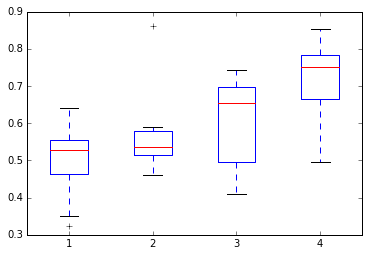

In [122]:
plt.boxplot(acc_all)
plt.show()

In [120]:
np.median(SOacc)

0.52755907491201603

In [115]:
np.median(ISpec_acc)

0.53692539188273758

In [116]:
np.median(PSpec_acc)

0.65345809825715107

In [117]:
np.median(DSpec_acc)

0.75005832890119217

In [123]:
np.savetxt('results.csv', acc_all, delimiter=',') 

## Global model simulations
Train on increasing number of healthy subjects (from 1 to 11) and test on 1 CBR patient. Run Nruns times by randomzing subjects in each run

* Healthy model

In [33]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Nruns = 1000 #total # of runs
Ntrain = len(HealthyData['SubjID'].unique()) #the total number of healthy to train on
Bacc_all = np.zeros((Nruns,Ntrain)) #contains the Bacc for each run 

t0 = time.time()
#loop through num subj to train on
for n in range(Ntrain):
    print 'train on {} subjects'.format(n+1)
    for run in range(1,Nruns+1):
        if run%100 == 0:
            print 'run={}/{}'.format(run,Nruns)       
        #pick n subj to train 
        np.random.shuffle(HealthyCodes)
        subjtrain = HealthyCodes[0:n+1]
        train = HealthyData.filter_by(subjtrain,'SubjID')
        test = np.random.shuffle(PatientCodes)
        subjtest = PatientCodes[0] #pick one subj to test
        test = CBRData.filter_by(subjtest,'SubjID')
        #print 'Run=%s, Train on subj %s, test on patient %s'%(run,train['SubjID'].unique(),test['SubjID'].unique())

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=50)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)

        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy for current run
        Bacc_all[run-1,n],acc_class = Balanced_acc(ypred,ytest)
        #print 'Bacc = {:.2f}'.format(Bacc_all[run,n])

t1 = time.time()
print 'Elapsed time=%.2f secs'%(t1-t0)

train on 1 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 2 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 3 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 4 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 5 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 6 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1000
run=700/1000
run=800/1000
run=900/1000
run=1000/1000
train on 7 subjects
run=100/1000
run=200/1000
run=300/1000
run=400/1000
run=500/1000
run=600/1

In [34]:
np.savetxt('results_GlobalH.csv', Bacc_all, delimiter=',') 

* Patients Model

In [31]:
col_names = SCOData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Nruns = 100 #total # of runs
Ntrain = len(SCOData['SubjID'].unique()) #the total number of patients (SCO)
Bacc_all = np.zeros((Nruns,Ntrain-1)) #contains the Bacc for each run 

t0 = time.time()
#loop through num subj to train on
for n in range(Ntrain-1): #-1 as one patient is out for test
    print 'train on {} subjects'.format(n+1)
    for run in range(1,Nruns+1):
        if run%10 == 0:
            print 'run={}/{}'.format(run,Nruns)       
        #pick n subj to train (use last for test)
        np.random.shuffle(PatientCodes)
        subjtrain = PatientCodes[0:n+1]
        train = SCOData.filter_by(subjtrain,'SubjID')
        subjtest = PatientCodes[n+1] #pick one patient to test (the last, not in train)
        test = CBRData.filter_by(subjtest,'SubjID')
        #print 'Run=%s, Train on subj %s, test on patient %s'%(run,train['SubjID'].unique(),test['SubjID'].unique())

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=100)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)

        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy for current run
        Bacc_all[run-1,n],acc_class = Balanced_acc(ypred,ytest)
        #print 'Bacc = {:.2f}'.format(Bacc_all[run-1,n])
t1 = time.time()
print 'Elapsed time=%.2f secs'%(t1-t0)

train on 1 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 2 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 3 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 4 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 5 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 6 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 7 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/100
run=70/100
run=80/100
run=90/100
run=100/100
train on 8 subjects
run=10/100
run=20/100
run=30/100
run=40/100
run=50/100
run=60/1

In [32]:
np.savetxt('results_GlobalP.csv', Bacc_all, delimiter=',') 